In [65]:
!pip install pyspark

In [66]:
from pyspark.sql import SparkSession
import os

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Read CSV with PySpark") \
    .getOrCreate()

# Path to the uploaded files
hospital_beds_file = "HospitalBedsIndia.csv"


statewise_testing_file = "StatewiseTestingDetails.csv"
covid_india_file = "covid_19_india.csv"
covid_vaccine_file = "covid_vaccine_statewise.csv"


# Function to check file existence and read CSV
def read_csv_file(file_path):
    if os.path.exists(file_path):
        return spark.read.csv(file_path, header=True, inferSchema=True)
    else:
        print(f"File not found: {file_path}")
        return None

# Read the CSV files
hospital_beds_df = read_csv_file(hospital_beds_file)


statewise_testing_df = read_csv_file(statewise_testing_file)
covid_india_df = read_csv_file(covid_india_file)
covid_vaccine_df = read_csv_file(covid_vaccine_file)





In [67]:
# reading the covid_19_india complete details
covid_india_df.printSchema()
#
covid_india_df.show(2)

root
 |-- Sno: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- State/UnionTerritory: string (nullable = true)
 |-- ConfirmedIndianNational: string (nullable = true)
 |-- ConfirmedForeignNational: string (nullable = true)
 |-- Cured: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Confirmed: integer (nullable = true)

+---+----------+-------+--------------------+-----------------------+------------------------+-----+------+---------+
|Sno|      Date|   Time|State/UnionTerritory|ConfirmedIndianNational|ConfirmedForeignNational|Cured|Deaths|Confirmed|
+---+----------+-------+--------------------+-----------------------+------------------------+-----+------+---------+
|  1|2020-01-30|6:00 PM|              Kerala|                      1|                       0|    0|     0|        1|
|  2|2020-01-31|6:00 PM|              Kerala|                      1|                       0|    0|     0|        1|
+---+----------+

In [68]:
# Create a temporary view
covid_india_df.createOrReplaceTempView("covid_india")

# Example SQL queries

# Query 1: Get the total number of confirmed cases
total_confirmed = spark.sql("SELECT SUM(Confirmed) as TotalConfirmed FROM covid_india")
total_confirmed.show()

# Query 2: Get the total number of deaths
total_deaths = spark.sql("SELECT SUM(Deaths) as TotalDeaths FROM covid_india")
total_deaths.show()

# Query 3: Get the total number of cured cases
total_cured = spark.sql("SELECT SUM(Cured) as TotalCured FROM covid_india")
total_cured.show()



+--------------+
|TotalConfirmed|
+--------------+
|    5451678687|
+--------------+

+-----------+
|TotalDeaths|
+-----------+
|   73389005|
+-----------+

+----------+
|TotalCured|
+----------+
|5046125452|
+----------+



In [69]:

# Query 4: Get the number of confirmed cases by State/UnionTerritory
confirmed_by_state = spark.sql("""
    SELECT `State/UnionTerritory`, SUM(Confirmed) as TotalConfirmed
    FROM covid_india
    GROUP BY `State/UnionTerritory`
    ORDER BY TotalConfirmed DESC
""")
confirmed_by_state.show()

# Query 5: Get the number of deaths by State/UnionTerritory
deaths_by_state = spark.sql("""
    SELECT `State/UnionTerritory`, SUM(Deaths) as TotalDeaths
    FROM covid_india
    GROUP BY `State/UnionTerritory`
    ORDER BY TotalDeaths DESC
""")
deaths_by_state.show()

+--------------------+--------------+
|State/UnionTerritory|TotalConfirmed|
+--------------------+--------------+
|         Maharashtra|    1121491467|
|           Karnataka|     485970693|
|              Kerala|     458906023|
|          Tamil Nadu|     431928644|
|      Andhra Pradesh|     392432753|
|       Uttar Pradesh|     312625843|
|               Delhi|     287227765|
|         West Bengal|     263107876|
|        Chhattisgarh|     163776262|
|           Rajasthan|     162369656|
|              Odisha|     160130533|
|             Gujarat|     143420082|
|      Madhya Pradesh|     135625265|
|             Haryana|     134347285|
|               Bihar|     132231166|
|              Punjab|      99949702|
|               Assam|      99837011|
|           Telengana|      69990668|
|           Jharkhand|      62111994|
|           Telangana|      60571979|
+--------------------+--------------+
only showing top 20 rows

+--------------------+-----------+
|State/UnionTerritory|Total

In [70]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import max as spark_max

# Assuming covid_india_df is already loaded with necessary data

# Group by State/UnionTerritory and get max values for Confirmed, Deaths, and Cured
state_cases = covid_india_df.groupBy('State/UnionTerritory').agg(
    spark_max('Confirmed').alias('Confirmed'),
    spark_max('Deaths').alias('Deaths'),
    spark_max('Cured').alias('Cured')
).toPandas()

# Calculate Active cases
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths'] + state_cases['Cured'])

# Calculate Death Rate and Cure Rate
state_cases["Death Rate (per 100)"] = np.round(100 * state_cases["Deaths"] / state_cases["Confirmed"], 2)
state_cases["Cure Rate (per 100)"] = np.round(100 * state_cases["Cured"] / state_cases["Confirmed"], 2)

# Sort values by Confirmed cases and fill NaN values with 0
state_cases_sorted = state_cases.sort_values('Confirmed', ascending=False).fillna(0)

# Apply background gradients for visualization
styled_state_cases = state_cases_sorted.style.background_gradient(cmap='Reds', subset=["Confirmed"]) \
                                            .background_gradient(cmap='Blues', subset=["Deaths"]) \
                                            .background_gradient(cmap='Greens', subset=["Cured"]) \
                                            .background_gradient(cmap='Purples', subset=["Active"]) \
                                            .background_gradient(cmap='Greys', subset=["Death Rate (per 100)"]) \
                                            .background_gradient(cmap='Oranges', subset=["Cure Rate (per 100)"])

# Display the styled DataFrame
styled_state_cases


,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
39,Maharashtra,6363442,134201,6159676,69565,2.110000,96.800000
9,Maharashtra***,6229596,130753,6000911,97932,2.100000,96.330000
3,Kerala,3586693,18004,3396184,172505,0.500000,94.690000
1,Karnataka,2921049,36848,2861499,22702,1.260000,97.960000
32,Karanataka,2885238,36197,2821491,27550,1.250000,97.790000
6,Tamil Nadu,2579130,34367,2524400,20363,1.330000,97.880000
10,Andhra Pradesh,1985182,13564,1952736,18882,0.680000,98.370000
44,Uttar Pradesh,1708812,22775,1685492,545,1.330000,98.640000
40,West Bengal,1534999,18252,1506532,10215,1.190000,98.150000
30,Delhi,1436852,25068,1411280,504,1.740000,98.220000


In [71]:
import IPython
IPython.display.HTML('<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1977187" data-url="https://flo.uri.sh/visualisation/1977187/embed"><script src="https://public.flourish.studio/resources/embed.js"></script></div>')

In [72]:
# total beds reading india hospital beds
hospital_beds_df.printSchema()
hospital_beds_df.show(2)

root
 |-- Sno: integer (nullable = true)
 |-- State/UT: string (nullable = true)
 |-- NumPrimaryHealthCenters_HMIS: string (nullable = true)
 |-- NumCommunityHealthCenters_HMIS: string (nullable = true)
 |-- NumSubDistrictHospitals_HMIS: string (nullable = true)
 |-- NumDistrictHospitals_HMIS: string (nullable = true)
 |-- TotalPublicHealthFacilities_HMIS: string (nullable = true)
 |-- NumPublicBeds_HMIS: string (nullable = true)
 |-- NumRuralHospitals_NHP18: integer (nullable = true)
 |-- NumRuralBeds_NHP18: integer (nullable = true)
 |-- NumUrbanHospitals_NHP18: integer (nullable = true)
 |-- NumUrbanBeds_NHP18: integer (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)

+---+--------------------+----------------------------+------------------------------+----------------------------+-------------------------+--------------------------------+------------------+-----------------------+------------------+-----------------------+------------------+

In [73]:
#Create a Separate Column for State and Total Beds Available in Descending Order
from pyspark.sql.functions import col

# Calculate total beds (HMIS + NHP18) and add a column for state
total_beds_df = hospital_beds_df.withColumn("TotalBeds", col("NumPublicBeds_HMIS").cast("int") + col("NumRuralBeds_NHP18") + col("NumUrbanBeds_NHP18"))

# Selecting only State/UT and TotalBeds columns, sorted by TotalBeds in descending order
state_total_beds = total_beds_df.select("State/UT", "TotalBeds").orderBy(col("TotalBeds").desc())

state_total_beds.show(10)  # Displaying top 10 states by total beds available


+--------------+---------+
|      State/UT|TotalBeds|
+--------------+---------+
|    Tamil Nadu|   150148|
| Uttar Pradesh|   134570|
|   West Bengal|   129729|
|     Karnataka|   126498|
|   Maharashtra|   120444|
|Andhra Pradesh|    83937|
|     Rajasthan|    83692|
|        Kerala|    77515|
|       Gujarat|    73409|
|Madhya Pradesh|    66979|
+--------------+---------+
only showing top 10 rows



In [74]:
# Create Columns for Different Categories of Facilities
# Adding columns for public beds + public facilities, district hospitals, rural, urban, primary + community health centers
facilities_df = hospital_beds_df.withColumn("PublicBeds_Facilities", col("NumPublicBeds_HMIS").cast("int") + col("TotalPublicHealthFacilities_HMIS").cast("int")) \
    .withColumn("DistrictHospitals", col("NumDistrictHospitals_HMIS").cast("int")) \
    .withColumn("RuralTotal", col("NumRuralHospitals_NHP18") * col("NumRuralBeds_NHP18")) \
    .withColumn("UrbanTotal", col("NumUrbanHospitals_NHP18") * col("NumUrbanBeds_NHP18")) \
    .withColumn("PrimaryCommunityHealth", col("NumPrimaryHealthCenters_HMIS").cast("int") + col("NumCommunityHealthCenters_HMIS").cast("int"))

facilities_df.select("State/UT", "PublicBeds_Facilities", "DistrictHospitals", "RuralTotal", "UrbanTotal", "PrimaryCommunityHealth").show(20)


+--------------------+---------------------+-----------------+----------+----------+----------------------+
|            State/UT|PublicBeds_Facilities|DistrictHospitals|RuralTotal|UrbanTotal|PrimaryCommunityHealth|
+--------------------+---------------------+-----------------+----------+----------+----------------------+
|Andaman & Nicobar...|                 1280|                3|     15525|      1500|                    31|
|      Andhra Pradesh|                62465|               20|   1250640|   1082770|                  1615|
|   Arunachal Pradesh|                 2519|               15|    444288|      2680|                   184|
|               Assam|                20335|               33|  12870144|    309900|                  1173|
|               Bihar|                19942|               43|   5657190|    611408|                  2070|
|          Chandigarh|                 3803|                4|         0|      3112|                    42|
|        Chhattisgarh|      

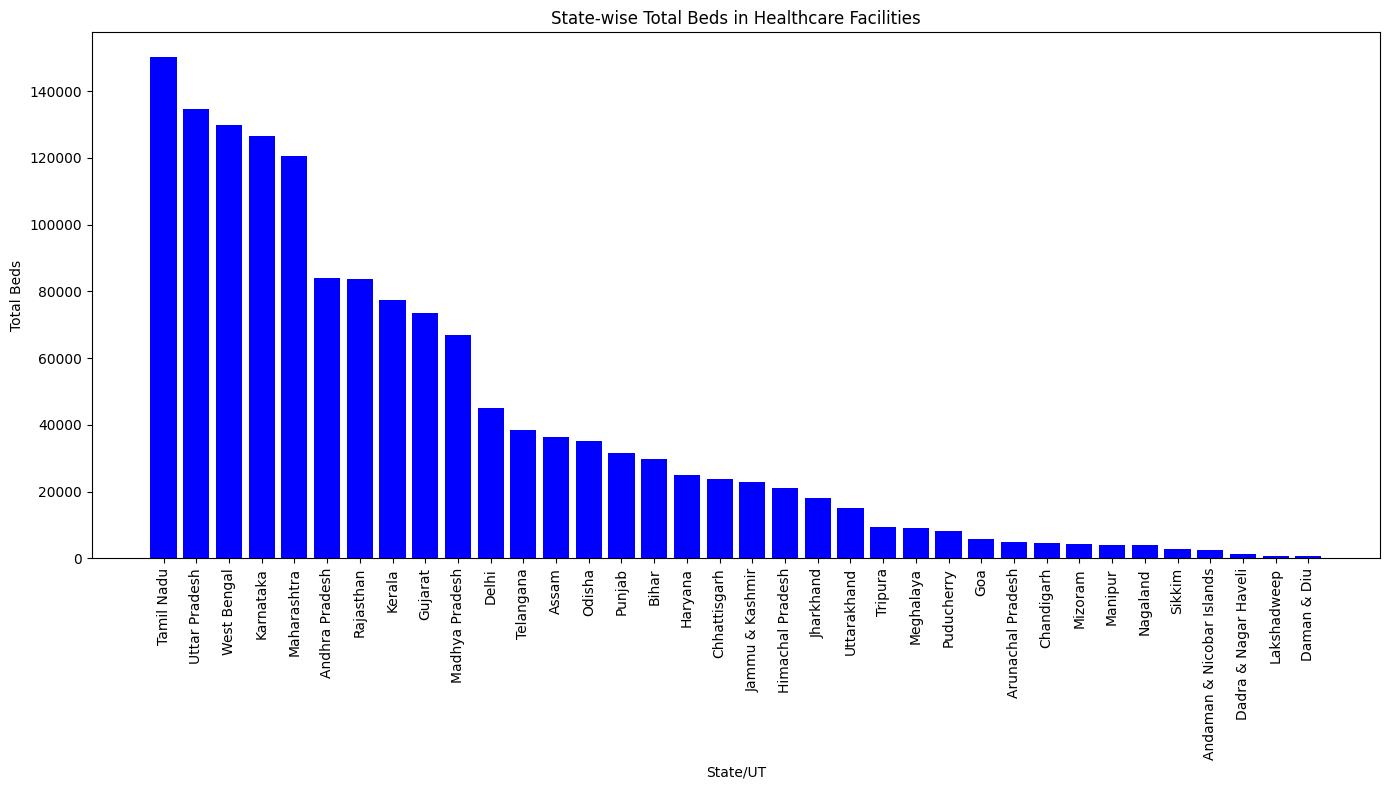

In [75]:
from pyspark.sql.functions import col

# Calculate total beds (HMIS + NHP18) and add a column for state
total_beds_df = hospital_beds_df.withColumn(
    "TotalBeds",
    col("NumPublicBeds_HMIS").cast("int") + col("NumRuralBeds_NHP18") + col("NumUrbanBeds_NHP18")
)

# Selecting only State/UT and TotalBeds columns, sorted by TotalBeds in descending order
state_total_beds = total_beds_df.select("State/UT", "TotalBeds").orderBy(col("TotalBeds").desc())

# Convert to Pandas DataFrame for plotting
state_total_beds_pd_df = state_total_beds.toPandas()

# Drop rows with None values (if any)
state_total_beds_pd_df.dropna(inplace=True)

# Plotting the bar chart
plt.figure(figsize=(14, 8))
plt.bar(state_total_beds_pd_df["State/UT"], state_total_beds_pd_df["TotalBeds"], color='blue')
plt.xlabel('State/UT')
plt.ylabel('Total Beds')
plt.title('State-wise Total Beds in Healthcare Facilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [76]:
#read the statewise testing details
statewise_testing_df.printSchema()
statewise_testing_df.show(2)

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- TotalSamples: double (nullable = true)
 |-- Negative: string (nullable = true)
 |-- Positive: double (nullable = true)

+----------+--------------------+------------+--------+--------+
|      Date|               State|TotalSamples|Negative|Positive|
+----------+--------------------+------------+--------+--------+
|2020-04-17|Andaman and Nicob...|      1403.0|    1210|    12.0|
|2020-04-24|Andaman and Nicob...|      2679.0|    NULL|    27.0|
+----------+--------------------+------------+--------+--------+
only showing top 2 rows



In [77]:
from pyspark.sql.functions import col, when, year, month, dayofmonth
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Convert 'Negative' column to numeric and handle missing values
statewise_testing_df = statewise_testing_df.withColumn('Negative', col('Negative').cast('double'))
statewise_testing_df = statewise_testing_df.withColumn('Negative', when(col('Negative').isNull(), 0).otherwise(col('Negative')))

# Handle missing values in the 'Positive' column
statewise_testing_df = statewise_testing_df.withColumn('Positive', col('Positive').cast('double'))
statewise_testing_df = statewise_testing_df.withColumn('Positive', when(col('Positive').isNull(), 0).otherwise(col('Positive')))

# Extract year, month, day from 'Date' column
statewise_testing_df = statewise_testing_df.withColumn('Year', year(col('Date')))
statewise_testing_df = statewise_testing_df.withColumn('Month', month(col('Date')))
statewise_testing_df = statewise_testing_df.withColumn('Day', dayofmonth(col('Date')))

# String indexer for 'State' column
state_indexer = StringIndexer(inputCol='State', outputCol='StateIndex')

# Define features and assembler
features = ['Year', 'Month', 'Day', 'StateIndex', 'Negative']
assembler = VectorAssembler(inputCols=features, outputCol='features')

# Initialize regression model
lr = LinearRegression(featuresCol='features', labelCol='Positive')

# Pipeline for assembling features and applying regression
pipeline = Pipeline(stages=[state_indexer, assembler, lr])

# Split data into training and testing sets
train_data, test_data = statewise_testing_df.randomSplit([0.8, 0.2], seed=123)

# Train the model
model = pipeline.fit(train_data)

# Predictions on test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Positive', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 99399.34741234855
R-squared (R2): 0.04352303754032261


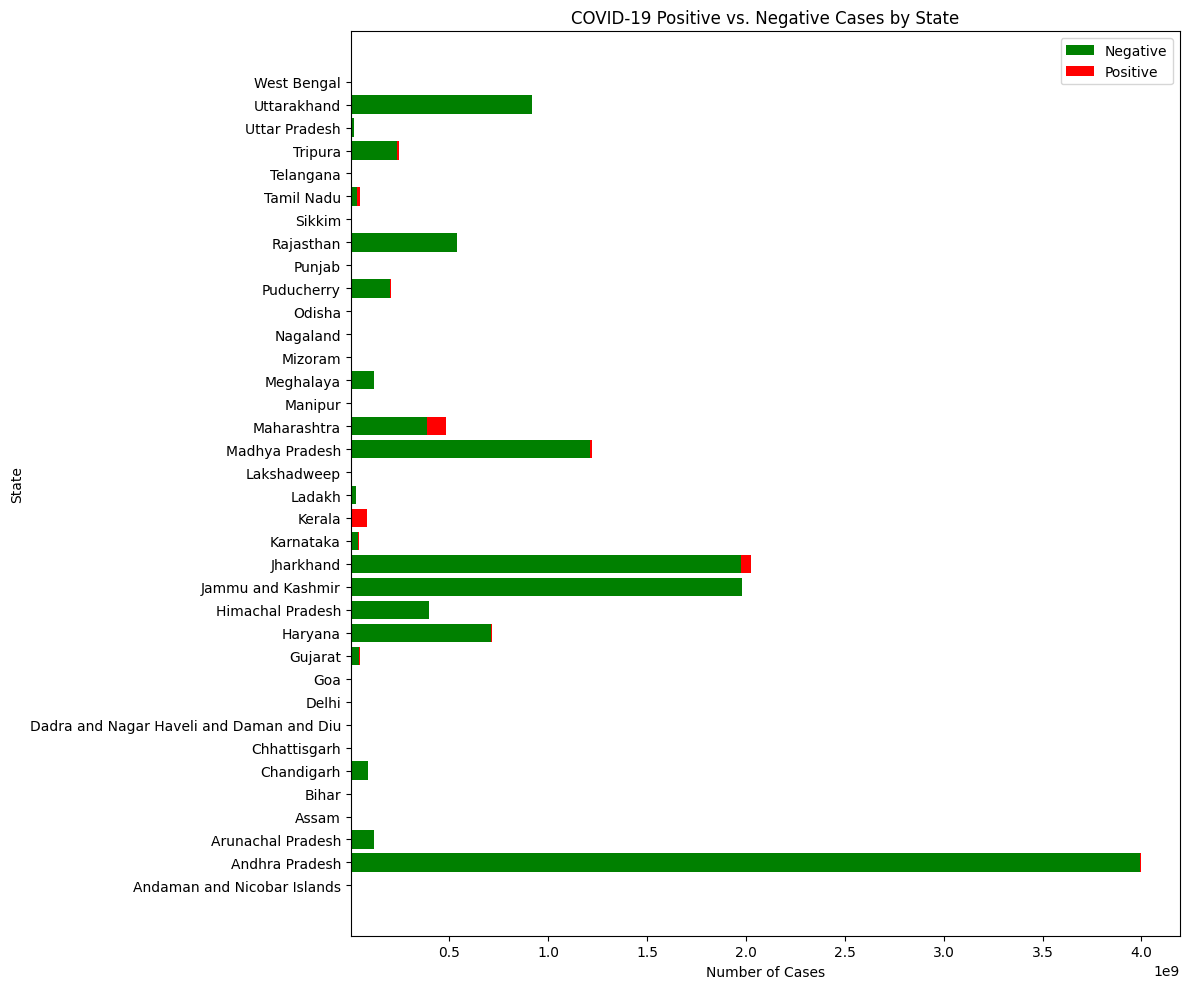

In [93]:
# Ensure statewise_testing_df is properly loaded as a Spark DataFrame
statewise_testing_df = spark.read.format("csv").option("header", "true").load(statewise_testing_file)

# Register the DataFrame as a temporary view to use with Spark SQL
statewise_testing_df.createOrReplaceTempView("statewise_testing")

# Perform SQL query to aggregate Positive and Negative cases by State
query = """
    SELECT State, SUM(Positive) AS Total_Positive, SUM(Negative) AS Total_Negative
    FROM statewise_testing
    GROUP BY State
    ORDER BY State
"""

# Execute SQL query
statewise_cases = spark.sql(query)

# Convert Spark DataFrame to Pandas for plotting
statewise_cases_pd = statewise_cases.toPandas()

# Plotting the data using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.barh(statewise_cases_pd['State'], statewise_cases_pd['Total_Negative'], label='Negative', color='green')
plt.barh(statewise_cases_pd['State'], statewise_cases_pd['Total_Positive'], left=statewise_cases_pd['Total_Negative'], label='Positive', color='red')

# Adding labels and title
plt.xlabel('Number of Cases')
plt.ylabel('State')
plt.title('COVID-19 Positive vs. Negative Cases by State')
plt.legend()
plt.tight_layout()
plt.show()


In [94]:
# SQL query to compute positive rate (Positive / TotalSamples) by State
query_positive_rate = """
    SELECT State,
           SUM(Positive) AS Total_Positive,
           SUM(TotalSamples) AS Total_Samples,
           SUM(Positive) / SUM(TotalSamples) AS Positive_Rate
    FROM statewise_testing
    GROUP BY State
    ORDER BY State
"""

# Execute SQL query
positive_rate_by_state = spark.sql(query_positive_rate)
positive_rate_by_state.show()


+--------------------+--------------+-------------+--------------------+
|               State|Total_Positive|Total_Samples|       Positive_Rate|
+--------------------+--------------+-------------+--------------------+
|Andaman and Nicob...|     1763591.0|  8.7470077E7|0.020162220732925614|
|      Andhra Pradesh|     3859260.0|4.967773349E9|7.768591135054217E-4|
|   Arunachal Pradesh|       51245.0| 1.63609581E8|3.132151533350605E-4|
|               Assam|     2065991.0|2.853509355E9|7.240176018276976E-4|
|               Bihar|     1859345.0|7.392796357E9|2.515076718215626...|
|          Chandigarh|       59195.0|  9.9747052E7|5.934511227459635E-4|
|        Chhattisgarh|      467857.0|1.863129277E9| 2.51113546319953E-4|
|Dadra and Nagar H...|      169010.0|    6324267.0|0.026724045648294104|
|               Delhi|     6848173.0|4.310596458E9|0.001588683391434272|
|                 Goa|      266181.0| 1.97906736E8|0.001344982012133...|
|             Gujarat|     8009517.0|4.623914093E9|

In [95]:
# SQL query to filter rows based on a date range
query_date_range = """
    SELECT *
    FROM statewise_testing
    WHERE Date >= '2020-04-01' AND Date <= '2020-04-30'
"""

# Execute SQL query
filtered_data = spark.sql(query_date_range)
filtered_data.show()


+----------+--------------------+------------+--------+--------+
|      Date|               State|TotalSamples|Negative|Positive|
+----------+--------------------+------------+--------+--------+
|2020-04-17|Andaman and Nicob...|      1403.0|    1210|    12.0|
|2020-04-24|Andaman and Nicob...|      2679.0|    NULL|    27.0|
|2020-04-27|Andaman and Nicob...|      2848.0|    NULL|    33.0|
|2020-04-02|      Andhra Pradesh|      1800.0|    1175|   132.0|
|2020-04-10|      Andhra Pradesh|      6374.0|    6009|   365.0|
|2020-04-11|      Andhra Pradesh|      6958.0|    6577|   381.0|
|2020-04-12|      Andhra Pradesh|      6958.0|    6553|   405.0|
|2020-04-13|      Andhra Pradesh|      8755.0|    8323|   432.0|
|2020-04-14|      Andhra Pradesh|     10505.0|   10032|   473.0|
|2020-04-15|      Andhra Pradesh|     11613.0|   11088|   525.0|
|2020-04-16|      Andhra Pradesh|     20235.0|   19701|   534.0|
|2020-04-17|      Andhra Pradesh|     20235.0|    NULL|   572.0|
|2020-04-18|      Andhra 

In [78]:
covid_vaccine_df.printSchema();
covid_vaccine_df.show(2)

root
 |-- Updated On: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Doses Administered: double (nullable = true)
 |-- Sessions: double (nullable = true)
 |--  Sites : double (nullable = true)
 |-- First Dose Administered: double (nullable = true)
 |-- Second Dose Administered: double (nullable = true)
 |-- Male (Doses Administered): double (nullable = true)
 |-- Female (Doses Administered): double (nullable = true)
 |-- Transgender (Doses Administered): double (nullable = true)
 |--  Covaxin (Doses Administered): double (nullable = true)
 |-- CoviShield (Doses Administered): double (nullable = true)
 |-- Sputnik V (Doses Administered): double (nullable = true)
 |-- AEFI: double (nullable = true)
 |-- 18-44 Years (Doses Administered): double (nullable = true)
 |-- 45-60 Years (Doses Administered): double (nullable = true)
 |-- 60+ Years (Doses Administered): double (nullable = true)
 |-- 18-44 Years(Individuals Vaccinated): double (nullable = true)
 |-- 45-60 

In [83]:
#Show the total number of individuals vaccinated by age group for each state
query5 = spark.sql("""
    SELECT State,
           SUM(`18-44 Years(Individuals Vaccinated)`) as Vaccinated_18_44,
           SUM(`45-60 Years(Individuals Vaccinated)`) as Vaccinated_45_60,
           SUM(`60+ Years(Individuals Vaccinated)`) as Vaccinated_60_plus
    FROM covid_vaccine
    GROUP BY State
    ORDER BY State
""")
query5.show()


+--------------------+----------------+----------------+------------------+
|               State|Vaccinated_18_44|Vaccinated_45_60|Vaccinated_60_plus|
+--------------------+----------------+----------------+------------------+
|Andaman and Nicob...|       1223324.0|       4376537.0|         2243271.0|
|      Andhra Pradesh|    1.01023557E8|     2.5420332E8|      1.87877645E8|
|   Arunachal Pradesh|       7460518.0|       8984788.0|         3566261.0|
|               Assam|     6.1397631E7|    1.07917402E8|       6.1222783E7|
|               Bihar|    1.45118819E8|     2.2569019E8|      2.64843188E8|
|          Chandigarh|       5287721.0|       7913481.0|         5823412.0|
|        Chhattisgarh|     4.1727384E7|    2.29332983E8|      1.48175206E8|
|Dadra and Nagar H...|       5054593.0|       4062240.0|         1719728.0|
|               Delhi|     9.0950668E7|     1.1931757E8|        8.231506E7|
|                 Goa|       7514873.0|     1.2191774E7|       1.1403306E7|
|           

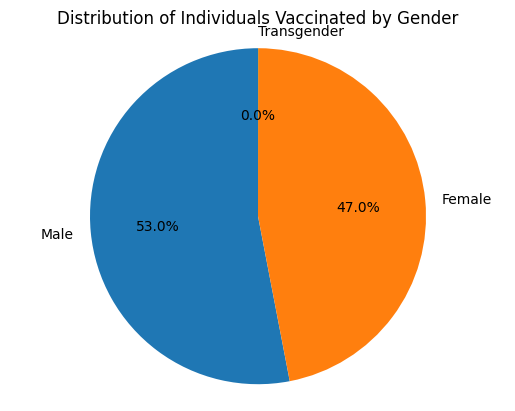

In [89]:
query6 = spark.sql("""
    SELECT State,
           SUM(`Male(Individuals Vaccinated)`) as Male_Vaccinated,
           SUM(`Female(Individuals Vaccinated)`) as Female_Vaccinated,
           SUM(`Transgender(Individuals Vaccinated)`) as Transgender_Vaccinated
    FROM covid_vaccine
    GROUP BY State
    ORDER BY State
""")

query6_data = query6.toPandas()
import matplotlib.pyplot as plt

# Sum the data for the pie chart
total_vaccinated = query6_data[['Male_Vaccinated', 'Female_Vaccinated', 'Transgender_Vaccinated']].sum()

# Data for the pie chart
labels = ['Male', 'Female', 'Transgender']
sizes = [total_vaccinated['Male_Vaccinated'], total_vaccinated['Female_Vaccinated'], total_vaccinated['Transgender_Vaccinated']]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Individuals Vaccinated by Gender')
plt.show()


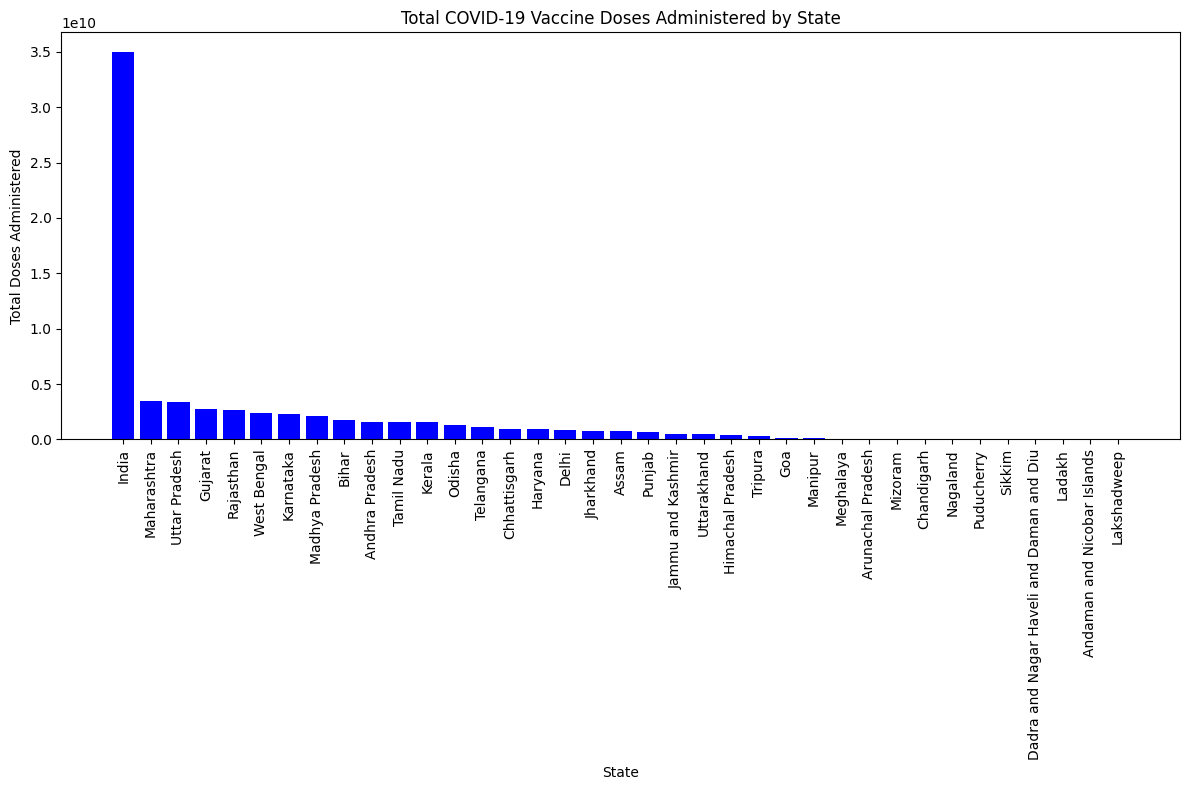

In [90]:
covid_vaccine_df.createOrReplaceTempView("covid_vaccine")

query1 = spark.sql("""
    SELECT State, SUM(`Total Doses Administered`) as Total_Doses_Administered
    FROM covid_vaccine
    GROUP BY State
    ORDER BY Total_Doses_Administered DESC
""")

query1_data = query1.toPandas()
covid_vaccine_df.createOrReplaceTempView("covid_vaccine")

import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(12, 8))
plt.bar(query1_data['State'], query1_data['Total_Doses_Administered'], color='blue')

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Total Doses Administered')
plt.title('Total COVID-19 Vaccine Doses Administered by State')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

